# Visualizing results

In [1]:
cd /home

/home


In [82]:
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
import toml
import wandb
import glob
import os

from src.utils import get_metrics

### Summary table

In [26]:
folder = './presentation/experiments/astromer_2/results/'
exp_folders = glob.glob(os.path.join(folder, '*', '*'))

In [57]:
metric_names= ['epoch_loss', 'epoch_rmse', 'epoch_r_square', 'epoch_bce', 'epoch_acc']

rows = []
for expdir in exp_folders:
    config_path = os.path.join(expdir, 'pretraining', 'config.toml')
    log_dir = os.path.join(expdir, 'pretraining', 'logs')
    
    with open(config_path, 'r') as f:
        config = toml.load(f)
    
    val_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name='epoch_loss')
    best_epoch = val_metrics['value'].astype(float).argmin() 
    
    for index, metric in enumerate(metric_names):
        train_metrics = get_metrics(os.path.join(log_dir, 'train'), metric_name=metric)
        valid_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name=metric)
        
        config[metric] = np.round(train_metrics.iloc[best_epoch]['value'], 3)
        config[metric+'_val'] = np.round(valid_metrics.iloc[best_epoch]['value'], 3)
        
    rows.append(pd.Series(config))
    
results = pd.concat(rows, axis=1).T

In [68]:
results_filtered =results[~((results['encoder_mode'] == 'normal') & (results['pe_dim'].isna()))]

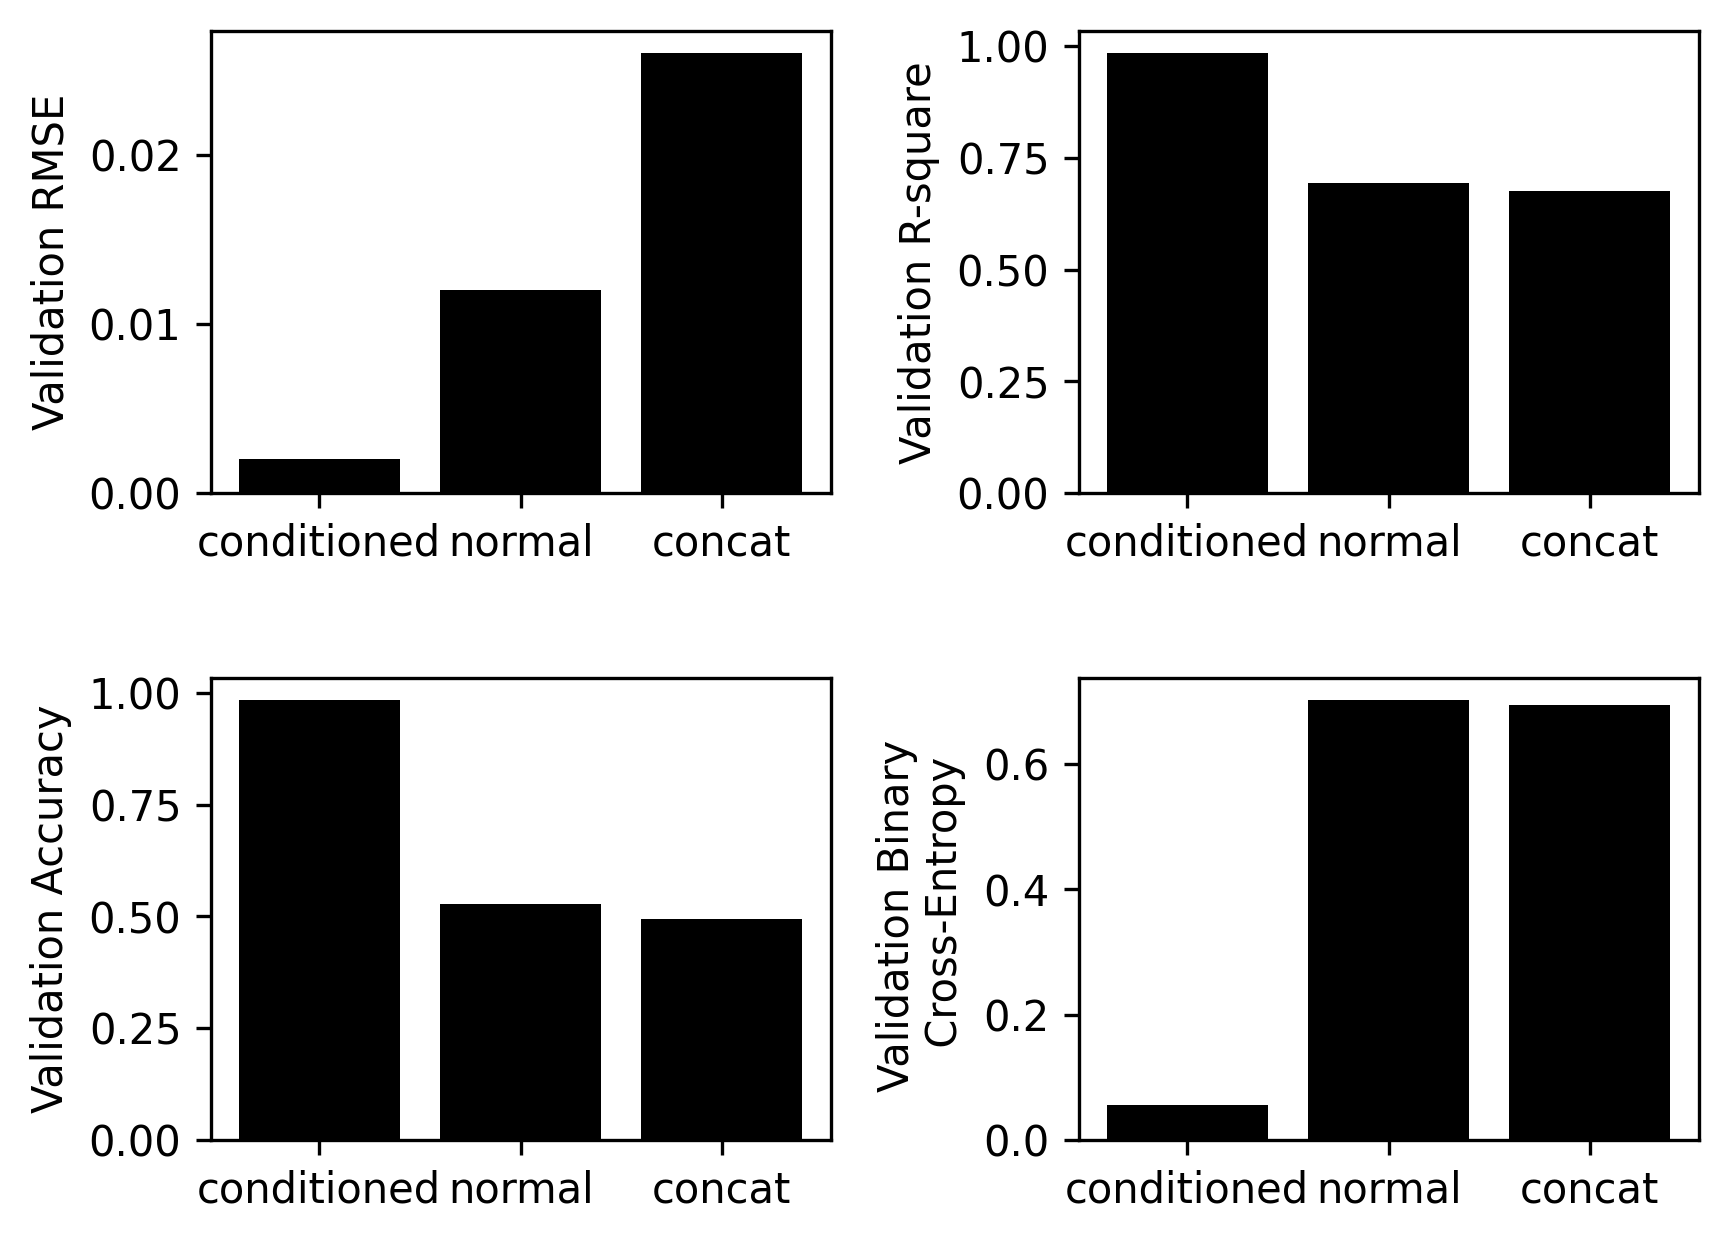

In [81]:
fig, axes = plt.subplots(2, 2, gridspec_kw={'hspace': 0.4, 'wspace': 0.4}, dpi=300)
axes = axes.flatten()
labels_name = {
    'epoch_rmse_val': 'Validation RMSE',
'epoch_r_square_val': 'Validation R-square',
'epoch_acc': 'Validation Accuracy',
'epoch_bce': 'Validation Binary \n Cross-Entropy',
}
for i, column in enumerate(['epoch_rmse_val', 'epoch_r_square_val', 'epoch_acc', 'epoch_bce']):
    axes[i].bar(results_filtered['encoder_mode'], results_filtered[column], color='k')
    axes[i].set_ylabel(labels_name[column])

### Visualize learning curves

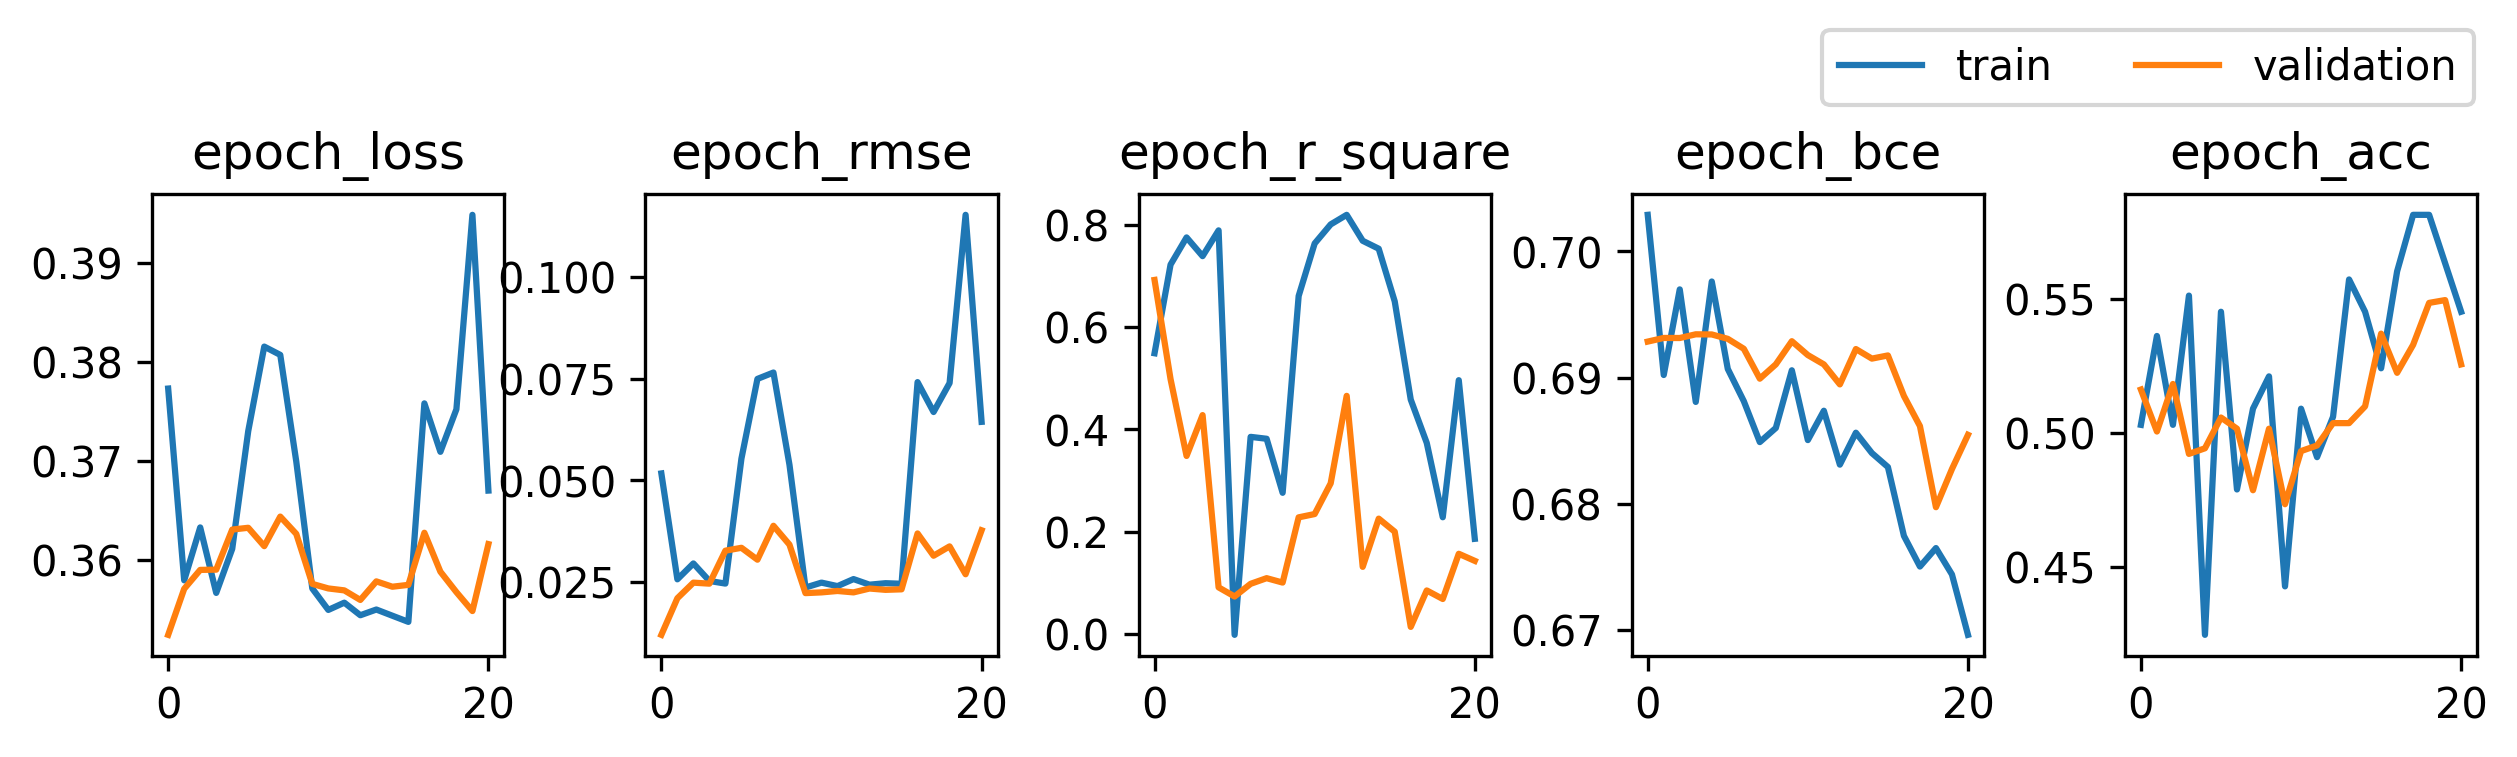

In [12]:
logs_path = './presentation/experiments/astromer_2/results/nsp_normal_bigpe/1_4_64_rmse_0.5/pretraining/logs/'

metric_names= ['epoch_loss', 'epoch_rmse', 'epoch_r_square', 'epoch_bce', 'epoch_acc']
fig, axes = plt.subplots(1, 5, figsize=(10,2), dpi=300, 
                        gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
for index, metric_name in enumerate(metric_names):
    train_metrics = get_metrics(logs_path+'train', metric_name=metric_name)
    valid_metrics = get_metrics(logs_path+'validation', metric_name=metric_name)
    
    axes[index].plot(train_metrics['value'], label='train')
    axes[index].plot(valid_metrics['value'], label='validation')
    axes[index].set_title(metric_name)

axes[-1].legend(bbox_to_anchor=(1.05, 1.4), ncols=2)

### Classification results

In [4]:
api = wandb.Api()
runs = api.runs(project_name)

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'batch_size', 'clf_name', 'dff', 'dropout_rate', 'fold', 'head_dim',
       'learning_rate', 'n_epochs', 'n_heads', 'n_layers', 'nsp_fraction',
       'nsp_prob', 'probed', 'pt_data', 'rand', 'subdataset', 'window_size',
       'epoch/acc', 'epoch/accuracy', 'epoch/bce', 'epoch/epoch',
       'epoch/learning_rate', 'epoch/loss', 'epoch/r_square', 'epoch/rmse',
       'epoch/val_acc', 'epoch/val_accuracy', 'epoch/val_bce',
       'epoch/val_loss', 'epoch/val_r_square', 'epoch/val_rmse', 'test_acc',
       'test_bce', 'test_f1', 'test_precision', 'test_r2', 'test_recall',
       'test_rmse'],
      dtype='object')

In [30]:
summary_mlp_att = summary[summary['clf_name'] == 'mlp_att']
summary_mlp_att = summary_mlp_att[['epoch/accuracy', 'subdataset', 'fold', 'n_layers']]
summary_mlp_att = summary_mlp_att.groupby(['n_layers', 'subdataset']).mean().reset_index()

In [31]:
astromer_0 = pd.read_csv('./presentation/experiments/astromer_0/wandb_tables/downstream.csv')

In [32]:
best_astro0 = astromer_0[(astromer_0['clf_name'] == 'mlp_att') & \
                         (astromer_0['window_size'] == 200) & \
                         (astromer_0['probed'] == 0.4) ]

best_astro0 = best_astro0[['dataset_to_ft', 'fold', 'epoch/val_accuracy']].groupby('dataset_to_ft')['epoch/val_accuracy'].mean().reset_index()

In [33]:
best_astro0

,dataset_to_ft,epoch/val_accuracy
0,alcock,0.536769
1,atlas,0.683333


Text(0, 0.5, 'Validation Accuracy')

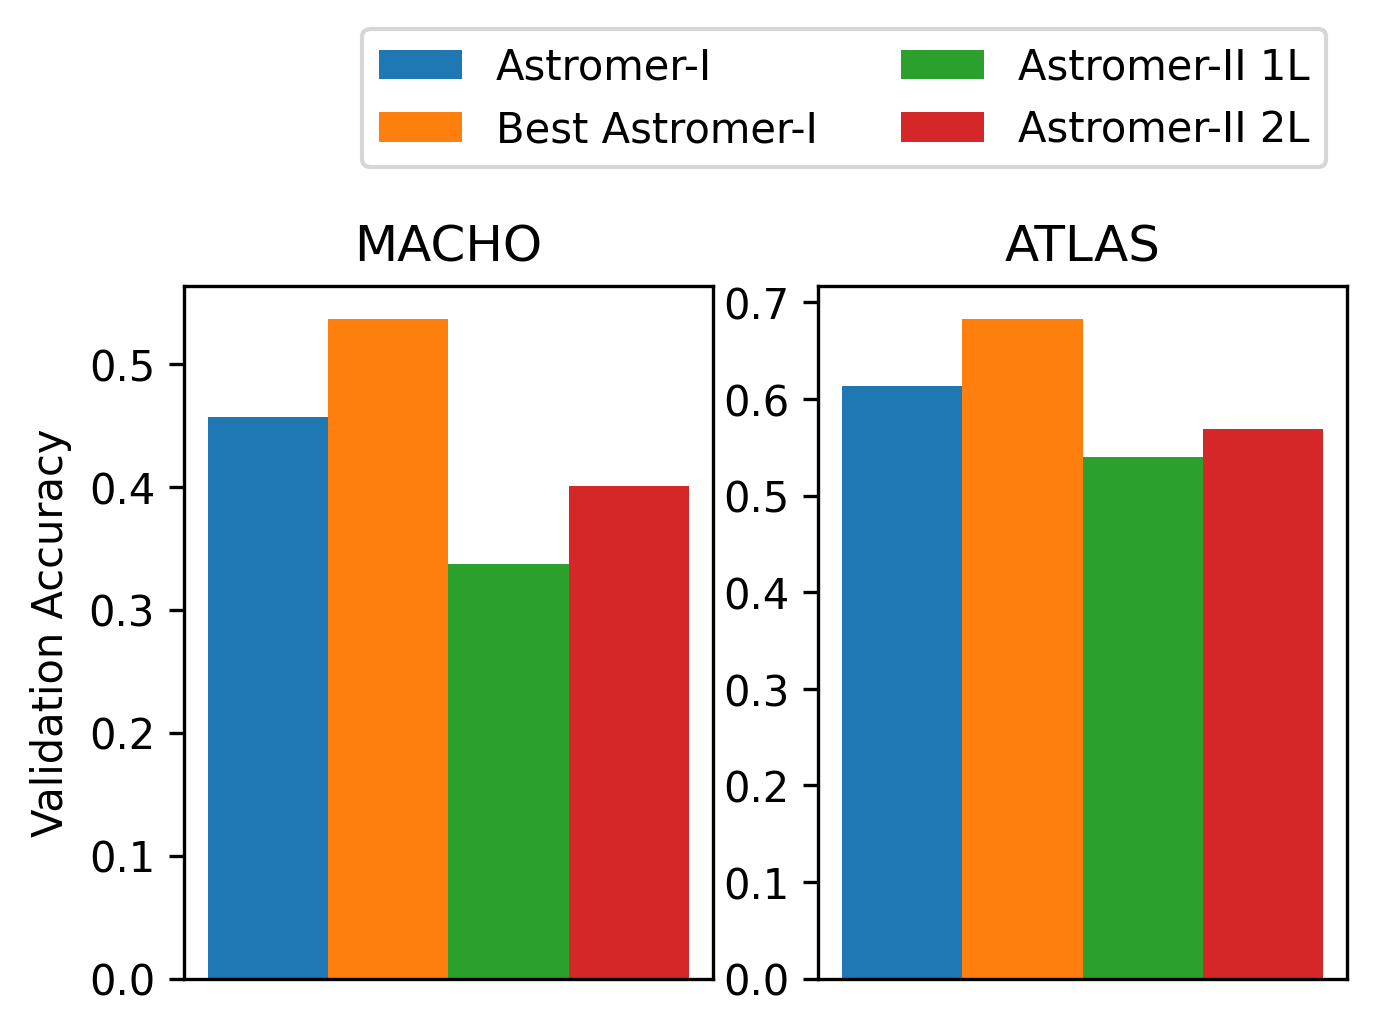

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(5,3), dpi=300)
ds_names = ['MACHO', 'ATLAS']
for k, ds in enumerate(['alcock', 'atlas']):
    
    astromer_old = pd.read_csv('./presentation/experiments/astromer_0/results_old/macho_mask_50_LR1e-05/{}/classification/metrics.csv'.format(ds))
    acc_old = astromer_old[(astromer_old['model'] == 'mlp_att') & \
                           (astromer_old['spc'] == 20) & \
                           (astromer_old['sci_case'] == 'a')][['val_acc']].mean().values[0]
    
    selected = best_astro0[best_astro0['dataset_to_ft']==ds]
    
    acc_best = selected['epoch/val_accuracy'].values[0]
    acc_nsp_1 = summary_mlp_att[(summary_mlp_att['subdataset'] == ds) & \
                                (summary_mlp_att['n_layers'] == 1)]
    acc_nsp_2 = summary_mlp_att[(summary_mlp_att['subdataset'] == ds) & \
                                (summary_mlp_att['n_layers'] == 2)]
    
    acc_nsp_1 = acc_nsp_1['epoch/accuracy'].values[0]
    acc_nsp_2 = acc_nsp_2['epoch/accuracy'].values[0]
    
    x_range = np.arange(3)
    axes[k].bar(-0.2,acc_old, 0.2, label = 'Astromer-I')
    axes[k].bar(0., acc_best, 0.2, label = 'Best Astromer-I')
    axes[k].bar(0.2,acc_nsp_1, 0.2, label = 'Astromer-II 1L')
    axes[k].bar(0.4, acc_nsp_2, 0.2, label = 'Astromer-II 2L')
    axes[k].set_title(ds_names[k])
    axes[k].set_xticks([])
    
axes[-1].legend(bbox_to_anchor=(1, 1.4), ncols=2)
axes[0].set_ylabel('Validation Accuracy')